# Adding J2 (Oblateness)

J2 or oblateness is the leading term in the expansion of the gravitational potential of an extended, azimuthally symmetric body, which is an important perturbation in a variety of astrophysical contexts (orbits around planets, stars, etc). Generally, this problem is too complex, because each object is distorted by a Roche-like potential (Horvath et al. 2020). Nevertheless, it is often useful to describe each rotating body by the J2 leading-order approximation, which acts on all other components. 

One limitation of the current implementation is that while different bodies can have arbitrary axes of rotation (and their resulting J2s can affect the orbits of other bodies), those rotation axes are treated as fixed. In other words, the current implementation neglects the torque of the orbiting body back onto the spin angular momentum, which would in general cause the rotation axis to also evolve with time. This is a good approximation in the limit where there is much more angular momentum in the body's spin than in the orbit. The effect uses the angular rotation rate Omega below to specify the spin axis orientation of the body, but the magnitude of the rotation is currently never used.

Let's start with a standard setup:

In [1]:
import rebound
import numpy as np
from math import pi
sim = rebound.Simulation()
sim.add(m = 1.)
sim.add(m = 3.e-6, a = 0.1, e = 0.01, inc = np.pi/6)
sim.move_to_com()
ps = sim.particles

Add the J2 force:

In [2]:
import reboundx
rebx = reboundx.Extras(sim)
gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)

And the respective J2 value (unitless), equatorial radius (in whatever units of distance you are using above), and spin axis orientation--here we use the z axis.

In [3]:
J2 = 0.01
Req = 1/200.
sim.particles[0].params["J2"] = J2
sim.particles[0].params["R_eq"] = Req
sim.particles[0].params["Omega"] = [0., 0., 1.]

We integrate as normal and store the arguments of pericenter (`omega`) and longitudes of ascending node (`Omega`). 

Note: It is unfortunate that $\Omega$ is a standard variable name both for the angular rotation rate, and an orbit's longitude of ascending node. `ps[1].Omega` is the longitude of ascending node of the orbit (indeed, every quantity calculated by REBOUND through `sim.particles[x].something` is for that body's *orbit*). ps[1].params['Omega'] is the angular rotation rate.

In [4]:
%%time
Nout = 1000
times = np.linspace(0, 5e3, Nout)
omegas = np.zeros(len(times))
Omegas = np.zeros(len(times))

for i, time in enumerate(times):
    sim.integrate(time)
    omegas[i] = ps[1].omega
    Omegas[i] = ps[1].Omega

# one liners to put our arrays of angles in the range [-pi, pi]
Omegas = np.mod(Omegas-np.pi, 2*np.pi)-np.pi
omegas = np.mod(omegas-np.pi, 2*np.pi)-np.pi

CPU times: user 3.98 s, sys: 515 ms, total: 4.49 s
Wall time: 3.54 s


As a verification, we also compute precession rates using analytical formulae (e.g., Oplistilova et al. 2020, Appendix A):

In [5]:
cosinc = np.dot(ps[1].hvec/np.linalg.norm(ps[1].hvec), ps[0].params['Omega']/np.linalg.norm(ps[0].params['Omega']))
omegadot = 3.*ps[1].n*J2*(Req/ps[1].a)**2 * (5.*cosinc**2-1.)/(4.*(1-ps[1].e**2)**2)
Omegadot = -3./2.*ps[1].n*J2*(Req/ps[1].a)**2 * cosinc/(1-ps[1].e**2)**2

Finally, let's plot the corresponding precession of omega, Omega:

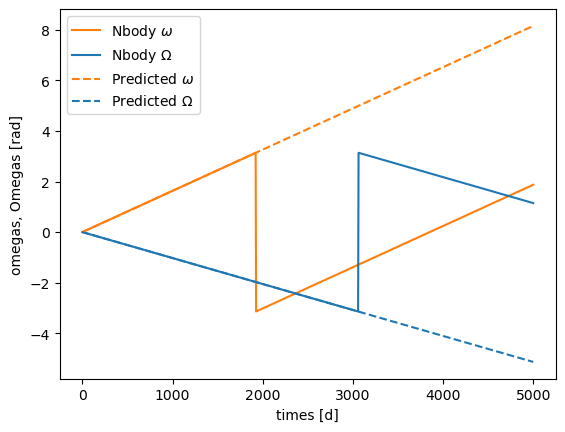

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(times, omegas, color='tab:orange', label=r'Nbody $\omega$')
ax.plot(times, Omegas, color='tab:blue', label=r'Nbody $\Omega$')
ax.plot(times, omegadot*times, color='tab:orange', linestyle='--', label=r'Predicted $\omega$')
ax.plot(times, Omegadot*times, color='tab:blue', linestyle='--', label=r'Predicted $\Omega$')
ax.set_xlabel("times [d]")
ax.set_ylabel("omegas, Omegas [rad]")
ax.legend()

The Nbody (solid) is visually indistinguishable from the predictions (dashed), except the Nbody results wrap once they reach $\pm \pi$. 

We could additionally have added a J4 by simply setting it above

In [7]:
ps[1].params['J4'] = 1e-3

and it would include it in the integration. No higher harmonics are currently implemented.

# Manipulating outputs in 3 dimensions

If possible, you would always want to choose the $z$ axis of your integration to be the star's fixed rotation axis to simplify the analysis (like we did above). But in many cases of interest this is not possible, and it can be tricky to visualize and calculate quantities of interest. For example, let's set up the same orbit as above for our planet:

In [8]:
sim = rebound.Simulation()
sim.add(m = 1.)
sim.add(m = 3.e-6, a = 0.1, e = 0.01, inc = np.pi/6)
sim.move_to_com()
ps = sim.particles

rebx = reboundx.Extras(sim)
gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)

but now let's make the spin axis of our star have a 60 degree obliquity to the z axis. 

In [9]:
obl = np.pi/3
sim.particles[0].params["J2"] = 0.01
sim.particles[0].params["R_eq"] = 1/200.
sim.particles[0].params["Omega"] = [0.0, -np.sin(obl), np.cos(obl)]

cosinc = np.dot(ps[1].hvec/np.linalg.norm(ps[1].hvec), ps[0].params['Omega']/np.linalg.norm(ps[0].params['Omega']))
omegadot = 3.*ps[1].n*J2*(Req/ps[1].a)**2 * (5.*cosinc**2-1.)/(4.*(1-ps[1].e**2)**2)
Omegadot = -3./2.*ps[1].n*J2*(Req/ps[1].a)**2 * cosinc/(1-ps[1].e**2)**2

In the above setup, our orbit's angular momentum and spin vector both lie in the yz plane, and have a negative y compoment

In [10]:
ps[1].hvec/np.linalg.norm(ps[1].hvec), ps[0].params['Omega']/np.linalg.norm(ps[0].params['Omega'])

(array([ 0.       , -0.5      ,  0.8660254]),
 <rebound.vectors.Vec3d object at 0x11e6147c0, [0.0, -0.8660254037844386, 0.5000000000000001]>)

and in particular, we have chosen the initial conditions so that there's still a $\pi/6$ angle between the orbit's angular momentum vector and the star's spin axis like we had above:

In [11]:
np.arccos(cosinc), np.pi/6

(0.5235987755982989, 0.5235987755982988)

Now we integrate as above, except we will also calculate the initial energy `E0`, incorporating the contribution from the J2 (and J4 if we had included it) by calling `rebx.gravitational_harmonics_potential()` and at each output calculating the relative energy error:

In [12]:
omegas, Omegas = np.zeros(len(times)), np.zeros(len(times))
Eerr = np.zeros(len(times))

E0 = sim.energy() + rebx.gravitational_harmonics_potential()
for i, time in enumerate(times):
    sim.integrate(time)
    omegas[i] = ps[1].omega
    Omegas[i] = sim.particles[1].Omega
    E = sim.energy() + rebx.gravitational_harmonics_potential()
    Eerr[i] = np.abs((E-E0)/E0)
    
# one liners to put our arrays of angles in the range [-pi, pi]
Omegas = np.mod(Omegas-np.pi, 2*np.pi)-np.pi
omegas = np.mod(omegas-np.pi, 2*np.pi)-np.pi

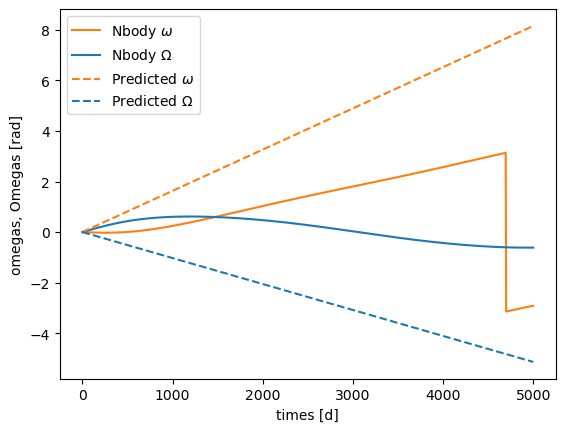

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(times, omegas, color='tab:orange', label=r'Nbody $\omega$')
ax.plot(times, Omegas, color='tab:blue', label=r'Nbody $\Omega$')
ax.plot(times, omegadot*times, color='tab:orange', linestyle='--', label=r'Predicted $\omega$')
ax.plot(times, Omegadot*times, color='tab:blue', linestyle='--', label=r'Predicted $\Omega$')
ax.set_xlabel("times [d]")
ax.set_ylabel("omegas, Omegas [rad]")
ax.legend()

We see that the predictions no longer match the Nbody integrations. But if we plot the energy error, we see that it remains near the machine precision:

Text(0, 0.5, 'Fractional Energy Error')

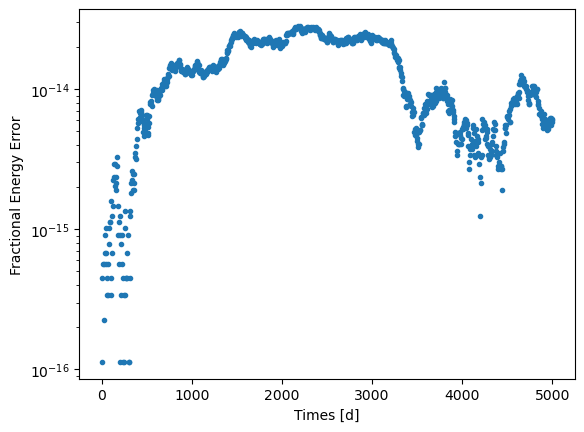

In [14]:
fig, ax = plt.subplots()
ax.plot(times, Eerr, '.')
ax.set_yscale('log')
ax.set_xlabel("Times [d]")
ax.set_ylabel("Fractional Energy Error")

The code is therefore calculating the oblateness perturbations correctly--the issue is that there is a mismatch in the definitions of our angles. 

The predictions are giving the precession rates in a coordinate system where the $z$ axis is aligned with the star's rotation axis (which provides an axis of symmetry), while REBOUND is calculating the orbital elements relative to the original reference frame that doesn't have $z$ lined up with the spin axis (we put the spin axis $\pi/3$ radians away from the z axis above).

To visualize this, let's redo our same setup

In [15]:
sim = rebound.Simulation()
sim.add(m = 1.)
sim.add(m = 3.e-6, a = 0.1, e = 0.01, inc = np.pi/6)
sim.move_to_com()
ps = sim.particles

rebx = reboundx.Extras(sim)
gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)

obl = np.pi/3
sim.particles[0].params["J2"] = 0.01
sim.particles[0].params["R_eq"] = 1/200.
sim.particles[0].params["Omega"] = [0.0, -np.sin(obl), np.cos(obl)]

and just store the orbit's angular momentum vector

In [16]:
hs = np.zeros((Nout, 3))

for i, time in enumerate(times):
    sim.integrate(time)
    hs[i] = ps[1].hvec

We can then plot the evolution of the orbital angular momentum vector (blue), and we see it precesses in a cone around the star's spin axis (fixed, in red).

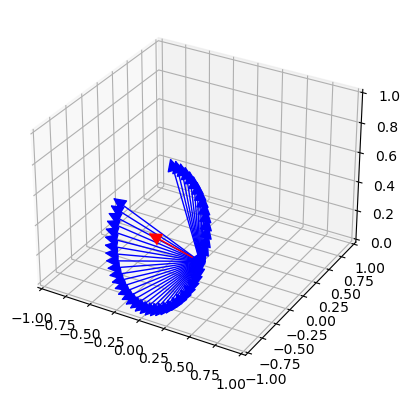

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# Adapted from CTZhu and Ruli on https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
default_arrow_props = dict(mutation_scale=20, arrowstyle='-|>', shrinkA=0, shrinkB=0)

class Arrow3D(FancyArrowPatch):
    def __init__(self, vec, c, scale=1, *args, **kwargs):
        super().__init__((0,0), (0,0), color=c, *args, **default_arrow_props, **kwargs)
        vec = np.array(vec, dtype=float)
        vec *= scale/np.linalg.norm(vec)
        self._verts3d = [0,vec[0]], [0,vec[1]], [0,vec[2]]

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.add_artist(Arrow3D(sim.particles[0].params['Omega'], c='r'))
for i in range(0,len(hs),20):
    a = Arrow3D(hs[i], c='b')
    ax.add_artist(a)

We can easily manipulate these sorts of rotations with REBOUND's built-in API, see [Rotations.ipynb](https://github.com/hannorein/rebound/blob/main/ipython_examples/Rotations.ipynb) as well as [SpinsIntro.ipynb](https://github.com/dtamayo/reboundx/blob/main/ipython_examples/SpinsIntro.ipynb) in the REBOUNDx documentation.

We can create a rotation from our coordinate system to a new one that aligns the $z$ axis with the star's spin:


In [18]:
rot = rebound.Rotation.to_new_axes(newz=ps[0].params['Omega'])

and then apply that rotation to our spin vector and each of the angular momenta:

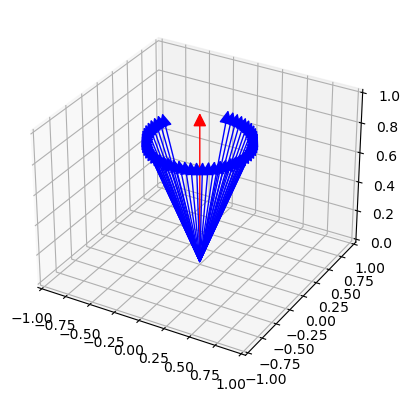

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.add_artist(Arrow3D(rot*sim.particles[0].params['Omega'], c='r'))
for i in range(0,len(hs),20):
    a = Arrow3D(rot*hs[i], c='b')
    ax.add_artist(a)

# Matching predictions

We could use this to match up the predicted node precession around the spin axis, but the argument of pericenter is trickier since it's defined relative to the (moving) node. Let's write a function to calculate the angle from one vector to another to help us calculate them, and set up our system as before:

In [20]:
def angle_from_to(a, b):
    # Takes a vector a (list or numpy array) and vector b, and calculates the angle FROM a TO b
    # counterclockwise as defined by the z axis of the coordinate system (in which the components are expressed)
    ahat = a/np.linalg.norm(a)
    bhat = b/np.linalg.norm(b)
    angle = np.arccos(np.dot(ahat, bhat))  # the angle between two vectors is always in [0, pi] if we can go in either direc.
    if np.cross(ahat, bhat)[2] < 0:# the angle FROM a TO b is either +/- angle depending on which direc. we go
        angle = -angle             # we can figure out the right direction by taking the cross product
    return angle

sim = rebound.Simulation()
sim.add(m = 1.)
sim.add(m = 3.e-6, a = 0.1, e = 0.01, inc = np.pi/6)
sim.move_to_com()
ps = sim.particles

rebx = reboundx.Extras(sim)
gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)

obl = np.pi/3
sim.particles[0].params["J2"] = 0.01
sim.particles[0].params["R_eq"] = 1/200.
sim.particles[0].params["Omega"] = [0.0, -np.sin(obl), np.cos(obl)]

cosinc = np.dot(ps[1].hvec/np.linalg.norm(ps[1].hvec), ps[0].params['Omega']/np.linalg.norm(ps[0].params['Omega']))
omegadot = 3.*ps[1].n*J2*(Req/ps[1].a)**2 * (5.*cosinc**2-1.)/(4.*(1-ps[1].e**2)**2)
Omegadot = -3./2.*ps[1].n*J2*(Req/ps[1].a)**2 * cosinc/(1-ps[1].e**2)**2

Now we can use the fact that the vector in the direction of the ascending node (between the equatorial plane of the star and the orbital plane of the planet) lies in the spin vector cross hvec direction, and use the definitions of $\Omega$ and $\omega$ to calculate them relative to the ascending node:

In [21]:
omegas, Omegas = np.zeros(Nout), np.zeros(Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    hvec = ps[1].hvec # vector in ang. mom. dir
    evec = ps[1].evec # vector pointed toward pericenter
    xhat = [1,0,0]    # x axis unit vector
    
    ascnode = np.cross(ps[0].params['Omega'], hvec) # asc. node is along spin cross hvec dir.
    Omegas[i] = angle_from_to(xhat, ascnode)
    omegas[i] = angle_from_to(ascnode, evec)

and now things match if we're careful about realizing that our initial condition now corresponds to an ascending node at $\Omega=\pi$, which means $\omega = \pi$ also.

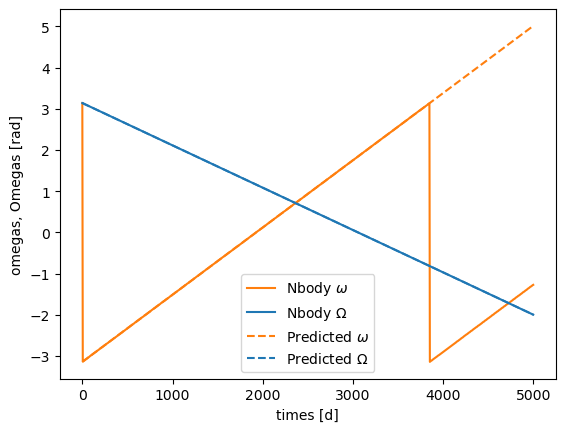

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(times, omegas, color='tab:orange', label=r'Nbody $\omega$')
ax.plot(times, Omegas, color='tab:blue', label=r'Nbody $\Omega$')
ax.plot(times, -np.pi+omegadot*times, color='tab:orange', linestyle='--', label=r'Predicted $\omega$')
ax.plot(times, np.pi+Omegadot*times, color='tab:blue', linestyle='--', label=r'Predicted $\Omega$')
ax.set_xlabel("times [d]")
ax.set_ylabel("omegas, Omegas [rad]")
ax.legend()